# MLE - G9: Confiabilidad de Modelos de Lenguaje

## 1. Imports necesarios

In [1]:
from dotenv import load_dotenv
import nltk
from functions.metamorphic import calculate_AFR, calculate_AFR_without_Bing
from functions.perturbations import delete_characters, add_characters, add_random_words, remplace_named_entities, replace_characters, replace_words_with_antonyms, replace_words_with_synonyms, delete_sentences
from functions.models import request_to_bing
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('punkt')
load_dotenv()

/Users/miguel/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/miguel/Library/Python/3.9/lib/python/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
[nltk_data] Downloading package punkt to /Users/miguel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 2. Comprobación de funcionamiento de Bing Chat

In [ ]:
import os
print(os.getenv("BING_U_COOKIE"))

In [ ]:
print(await request_to_bing("What is the capital of Spain?"))

## 3. Modelos a evaluar 

In [2]:
models = [
    ('summarize', 'facebook/bart-large-cnn'),
    ('summarize', 'google/pegasus-large'),
    ('toxic', 's-nlp/roberta_toxicity_classifier'),
    ('toxic', 'citizenlab/distilbert-base-multilingual-cased-toxicity', 'inputs'),
    ('spam', 'h-e-l-l-o/email-spam-classification-merged'),
    ('spam', 'dima806/email-spam-detection-roberta'),
    ('translate', 't5-base'),
    ('translate', 'allenai/wmt16-en-de-12-1'),
    ('fillmask', 'vinai/bertweet-base', '<mask>'),
    ('fillmask', 'roberta-base', '<mask>'),
]

summarize_models = [models[0], models[1]]
toxic_models = [models[2], models[3]]
spam_models = [models[4], models[5]]
translate_models = [models[6], models[7]]
fillmask_models = [models[8], models[9]]

## 4. Evaluación de modelos haciendo uso de BING Chat

In [3]:
perturbations = [(delete_characters, False, 'delete_characters'), (replace_characters, False, 'replace_characters'), (add_characters, False, 'add_characters'),(replace_words_with_synonyms, False, 'replace_word_synonyms'), (replace_words_with_antonyms, True,'replace_word_antonyms'), (add_random_words, False,'add_random_words'), (remplace_named_entities, False,'remplace_named_entities')]
attributes = ["Robustness", "Non-determinism", "Fairness"]

In [8]:
async def AFR(models, perturbations, attributes):
    RESULTS = pd.DataFrame(columns=["Value", "Time"])
    for model in models:
        m_type = model[0]
        for perturbation in perturbations:
            new_attributes = attributes.copy() if m_type != "summarize" else attributes.copy()[:-1]
            for attribute in new_attributes:
                print(model[0], model[1], perturbation[2], attribute)
                AFR, t = await calculate_AFR(model, perturbation[0], attribute, perturbation[2], perturbation[1], iterations=1)
                print(AFR, t)
                RESULTS.loc[model[0] + " - " + model[1] + " - " + perturbation[2] + " - " + attribute] = [AFR, t]

    return RESULTS

In [ ]:
summarize_results = await AFR(summarize_models, perturbations, attributes)
summarize_results

In [ ]:
toxic_results = await AFR(toxic_models, perturbations, attributes)
toxic_results

In [ ]:
spam_results = await AFR(spam_models, perturbations, attributes)
spam_results

In [ ]:
translate_results = await AFR(translate_models, perturbations, attributes)
translate_results

In [ ]:
fill_masks_results = await AFR(fillmask_models, perturbations, attributes)
fill_masks_results

## 5. Evaluación de modelos sin hacer uso de BING Chat

In [3]:
perturbations_without_bing = [(delete_characters, False, 'delete_characters'), (replace_characters, False, 'replace_characters'), (add_characters, False, 'add_characters')]
attributes_without_bing = ["Robustness"]

In [4]:
async def AFR_without_Bing(models, perturbations, attributes, iterations = 1):
    RESULTS = pd.DataFrame(columns=["Value", "Time"])
    for model in models:
        for perturbation in perturbations:
            for attribute in attributes:
                print(model[0], model[1], perturbation[2], attribute)
                AFR, M = await calculate_AFR_without_Bing(model, perturbation[0], attribute, perturbation[1], iterations=iterations)
                print(AFR, M)
                RESULTS.loc[model[0] + " - " + model[1] + " - " + perturbation[2] + " - " + attribute] = [AFR, M]

    return RESULTS

In [5]:
# Load Hugging Face models

await AFR_without_Bing(summarize_models, perturbations_without_bing, attributes_without_bing, iterations=1)

# Execute tests

summarize_results = await AFR_without_Bing(summarize_models, perturbations_without_bing, attributes_without_bing, iterations=10)
summarize_results

summarize facebook/bart-large-cnn delete_characters Robustness
1.0 8.390763998031616
summarize facebook/bart-large-cnn replace_characters Robustness


In [6]:
# Load Hugging Face models

await AFR_without_Bing(toxic_models, perturbations_without_bing, attributes_without_bing, iterations=1)

# Execute tests

toxic_results = await AFR_without_Bing(toxic_models, perturbations_without_bing, attributes_without_bing, iterations=10)
toxic_results

toxic s-nlp/roberta_toxicity_classifier delete_characters Robustness
1.0 24.27337384223938
toxic s-nlp/roberta_toxicity_classifier replace_characters Robustness
1.0 1.9197351932525635
toxic s-nlp/roberta_toxicity_classifier add_characters Robustness
1.0 2.2854931354522705
toxic citizenlab/distilbert-base-multilingual-cased-toxicity delete_characters Robustness
1.0 12.745358943939209
toxic citizenlab/distilbert-base-multilingual-cased-toxicity replace_characters Robustness
1.0 1.7624127864837646
toxic citizenlab/distilbert-base-multilingual-cased-toxicity add_characters Robustness
0.0 1.6801831722259521
toxic s-nlp/roberta_toxicity_classifier delete_characters Robustness
1.0 17.516135931015015
toxic s-nlp/roberta_toxicity_classifier replace_characters Robustness
1.0 18.540517807006836
toxic s-nlp/roberta_toxicity_classifier add_characters Robustness
1.0 18.502485752105713
toxic citizenlab/distilbert-base-multilingual-cased-toxicity delete_characters Robustness
1.0 18.05757188796997
toxi

,Value,Time
toxic - s-nlp/roberta_toxicity_classifier - delete_characters - Robustness,1.0,17.516136
toxic - s-nlp/roberta_toxicity_classifier - replace_characters - Robustness,1.0,18.540518
toxic - s-nlp/roberta_toxicity_classifier - add_characters - Robustness,1.0,18.502486
toxic - citizenlab/distilbert-base-multilingual-cased-toxicity - delete_characters - Robustness,1.0,18.057572
toxic - citizenlab/distilbert-base-multilingual-cased-toxicity - replace_characters - Robustness,0.8,70.953297
toxic - citizenlab/distilbert-base-multilingual-cased-toxicity - add_characters - Robustness,0.3,249.341876


In [7]:
# Load Hugging Face models

await AFR_without_Bing(spam_models, perturbations_without_bing, attributes_without_bing, iterations=1)

# Execute tests

spam_results = await AFR_without_Bing(spam_models, perturbations_without_bing, attributes_without_bing, iterations=10)
spam_results

spam h-e-l-l-o/email-spam-classification-merged delete_characters Robustness
1.0 12.156183958053589
spam h-e-l-l-o/email-spam-classification-merged replace_characters Robustness
1.0 2.161012887954712
spam h-e-l-l-o/email-spam-classification-merged add_characters Robustness
1.0 1.4265260696411133
spam dima806/email-spam-detection-roberta delete_characters Robustness
1.0 28.870464086532593
spam dima806/email-spam-detection-roberta replace_characters Robustness
1.0 4.369048118591309
spam dima806/email-spam-detection-roberta add_characters Robustness
1.0 1.9732720851898193
spam h-e-l-l-o/email-spam-classification-merged delete_characters Robustness
0.7 12.30972957611084
spam h-e-l-l-o/email-spam-classification-merged replace_characters Robustness
1.0 11.82557988166809
spam h-e-l-l-o/email-spam-classification-merged add_characters Robustness
0.9 13.88056492805481
spam dima806/email-spam-detection-roberta delete_characters Robustness
0.9 15.225166082382202
spam dima806/email-spam-detection-r

,Value,Time
spam - h-e-l-l-o/email-spam-classification-merged - delete_characters - Robustness,0.7,12.309730
spam - h-e-l-l-o/email-spam-classification-merged - replace_characters - Robustness,1.0,11.825580
spam - h-e-l-l-o/email-spam-classification-merged - add_characters - Robustness,0.9,13.880565
spam - dima806/email-spam-detection-roberta - delete_characters - Robustness,0.9,15.225166
spam - dima806/email-spam-detection-roberta - replace_characters - Robustness,1.0,14.935669
spam - dima806/email-spam-detection-roberta - add_characters - Robustness,0.6,13.508360


In [8]:
# Load Hugging Face models

await AFR_without_Bing(translate_models, perturbations_without_bing, attributes_without_bing, iterations=1)

# Execute tests

translate_results = await AFR_without_Bing(translate_models, perturbations_without_bing, attributes_without_bing, iterations=10)
translate_results

translate t5-base delete_characters Robustness
1.0 5.038265228271484
translate t5-base replace_characters Robustness
0.0 6.549903154373169
translate t5-base add_characters Robustness
1.0 4.1953558921813965
translate allenai/wmt16-en-de-12-1 delete_characters Robustness
0.0 34.40469193458557
translate allenai/wmt16-en-de-12-1 replace_characters Robustness
1.0 2.3533408641815186
translate allenai/wmt16-en-de-12-1 add_characters Robustness
1.0 2.155761957168579
translate t5-base delete_characters Robustness
0.8 56.932579040527344
translate t5-base replace_characters Robustness
0.5 61.54389405250549
translate t5-base add_characters Robustness
0.6 61.836000204086304
translate allenai/wmt16-en-de-12-1 delete_characters Robustness
0.6 20.04793906211853
translate allenai/wmt16-en-de-12-1 replace_characters Robustness
0.7 20.913851022720337
translate allenai/wmt16-en-de-12-1 add_characters Robustness
0.1 20.375965118408203


,Value,Time
translate - t5-base - delete_characters - Robustness,0.8,56.932579
translate - t5-base - replace_characters - Robustness,0.5,61.543894
translate - t5-base - add_characters - Robustness,0.6,61.836000
translate - allenai/wmt16-en-de-12-1 - delete_characters - Robustness,0.6,20.047939
translate - allenai/wmt16-en-de-12-1 - replace_characters - Robustness,0.7,20.913851
translate - allenai/wmt16-en-de-12-1 - add_characters - Robustness,0.1,20.375965


In [ ]:
# Load Hugging Face models

await AFR_without_Bing(fillmask_models, perturbations_without_bing, attributes_without_bing, iterations=1)

# Execute tests

fill_masks_results = await AFR_without_Bing(fillmask_models, perturbations_without_bing, attributes_without_bing, iterations=10)
fill_masks_results

Exportación de resultados:

In [15]:
summarize_results.to_csv('./results/results.csv', mode='a', header=False)
toxic_results.to_csv('./results/results.csv', mode='a', header=False)
spam_results.to_csv('./results/results.csv', mode='a', header=False)
translate_results.to_csv('./results/results.csv', mode='a', header=False)
fill_masks_results.to_csv('./results/results.csv', mode='a', header=False)

## 6. Visualizaciones

Lectura de los datos

In [2]:
df = pd.read_csv('./results/results.csv', header=None, names=['Columna1', 'Score', 'Time'])

df[['Task', 'Model', 'Perturbation', 'Attribute']] = df['Columna1'].str.split(' - ', expand=True)

df['Score'] = pd.to_numeric(df['Score'])
df['Time'] = pd.to_numeric(df['Time'])

df = df.drop(columns=['Columna1'])

df.head()

,Score,Time,Task,Model,Perturbation,Attribute
0,0.7,92.932588,summarize,facebook/bart-large-cnn,delete_characters,Robustness
1,0.8,96.799514,summarize,facebook/bart-large-cnn,replace_characters,Robustness
2,0.8,97.193827,summarize,facebook/bart-large-cnn,add_characters,Robustness
3,0.9,120.307742,summarize,google/pegasus-large,delete_characters,Robustness
4,0.8,102.613542,summarize,google/pegasus-large,replace_characters,Robustness


Score promedio por tarea

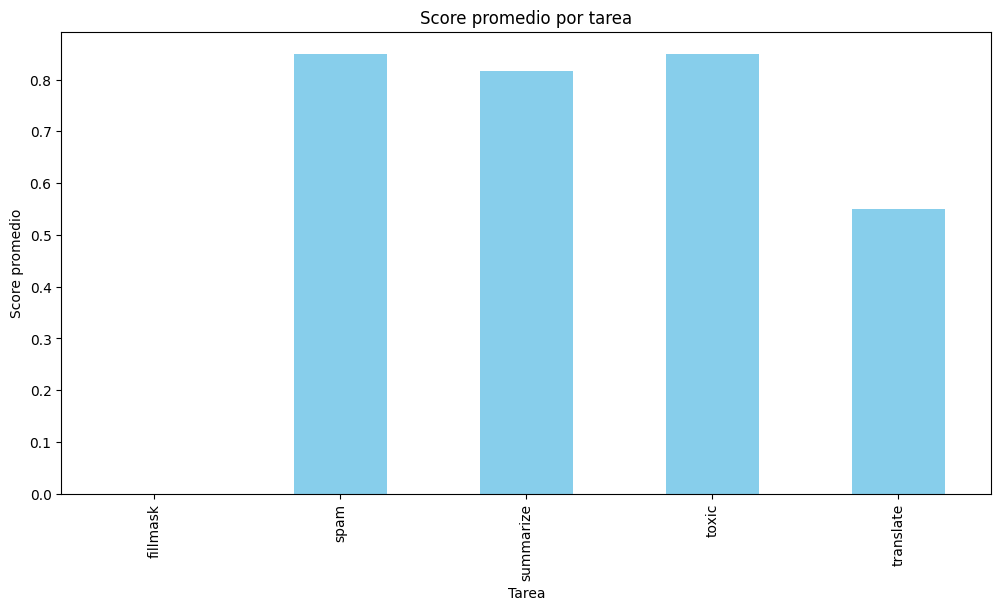

In [31]:
plt.figure(figsize=(12, 6))
df.groupby('Task')['Score'].mean().plot(kind='bar', color='skyblue')
plt.title('Score promedio por tarea')
plt.xlabel('Tarea')
plt.ylabel('Score promedio')
plt.show()

Tiempo vs. Score

/var/folders/wx/mr55ds4s2h51z7w0fl0gb1yw0000gn/T/ipykernel_1238/1072614750.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['Time'], df['Score'], cmap='viridis', alpha=0.7)


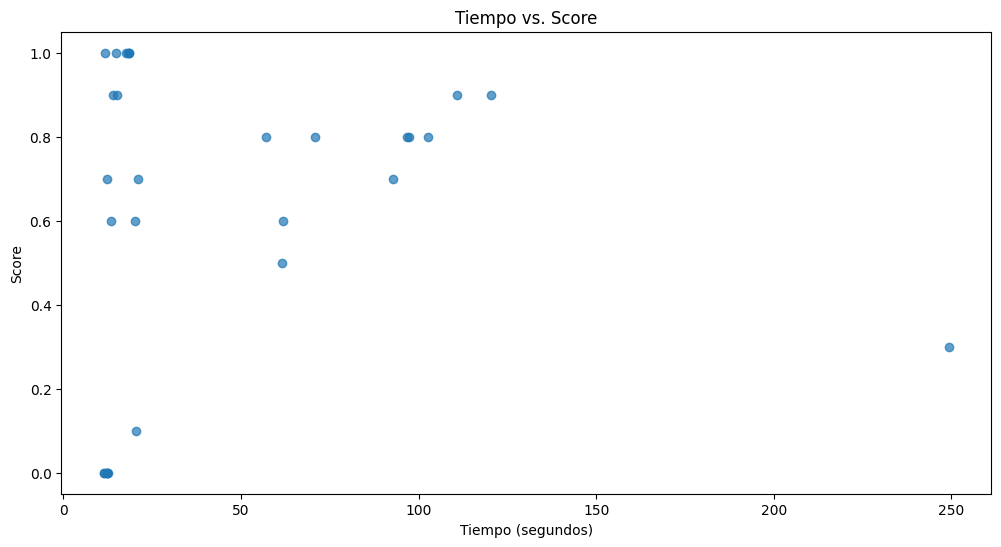

In [3]:
plt.figure(figsize=(12, 6))
plt.scatter(df['Time'], df['Score'], cmap='viridis', alpha=0.7)
plt.title('Tiempo vs. Score')
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Score')
plt.show()

Boxplot para Comparar la Distribución de los Scores por Tarea

/var/folders/wx/mr55ds4s2h51z7w0fl0gb1yw0000gn/T/ipykernel_3705/2180752474.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Task', y='Score', data=df, palette='viridis')


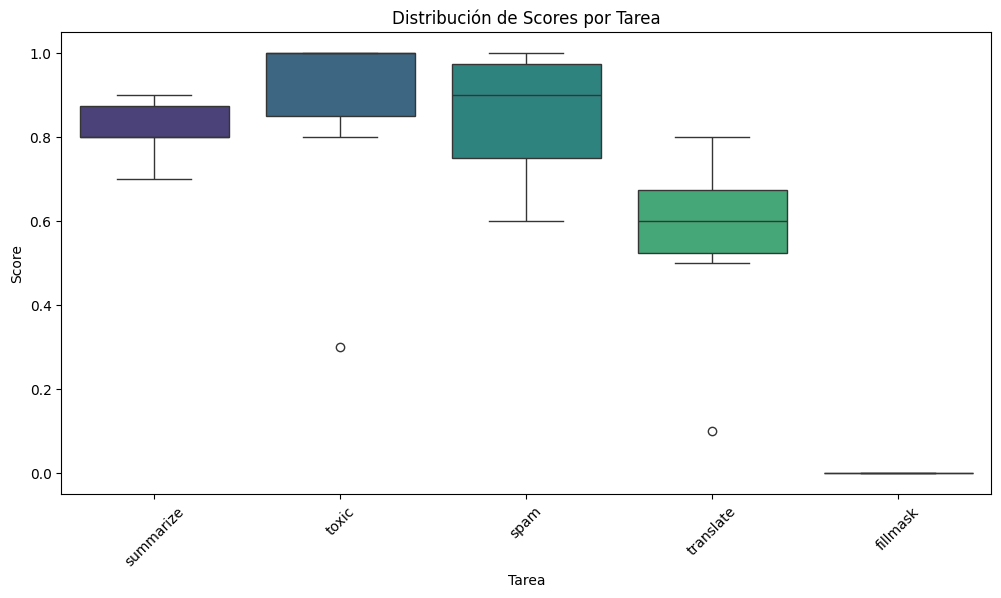

In [20]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Task', y='Score', data=df, palette='viridis')
plt.title('Distribución de Scores por Tarea')
plt.xlabel('Tarea')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()


Distribución de Tiempos por Tarea

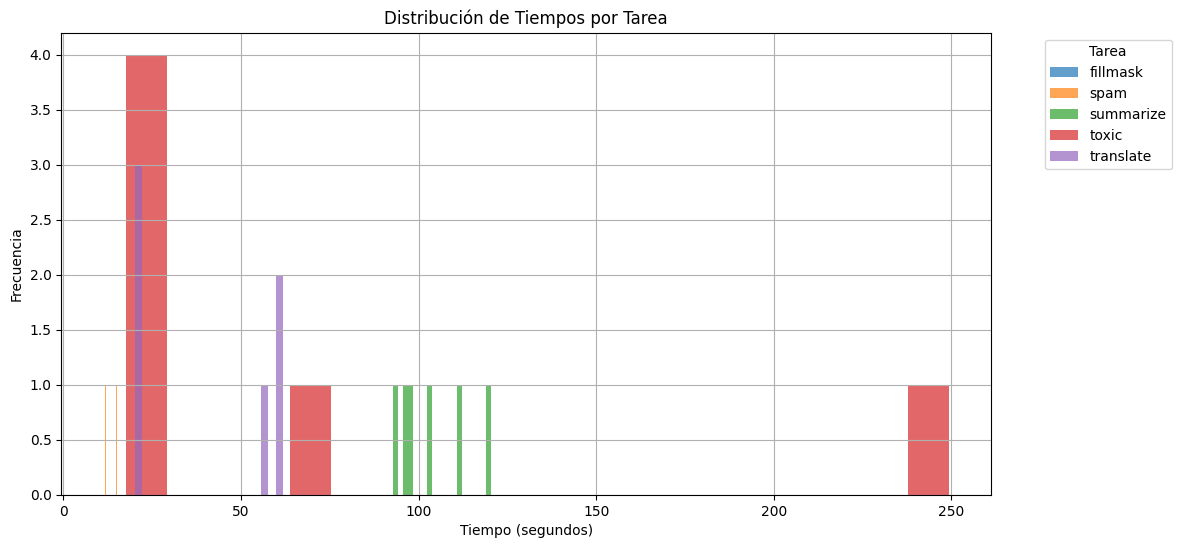

In [4]:
plt.figure(figsize=(12, 6))
df.groupby('Task')['Time'].hist(alpha=0.7, bins=20, stacked=True, legend=True, figsize=(12, 6))
plt.title('Distribución de Tiempos por Tarea')
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Frecuencia')
plt.legend(title='Tarea', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



Gráfico de Violín para Distribución de Tiempo por Modelo

/var/folders/wx/mr55ds4s2h51z7w0fl0gb1yw0000gn/T/ipykernel_1238/3821346421.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Model', y='Time', data=df, palette='viridis')


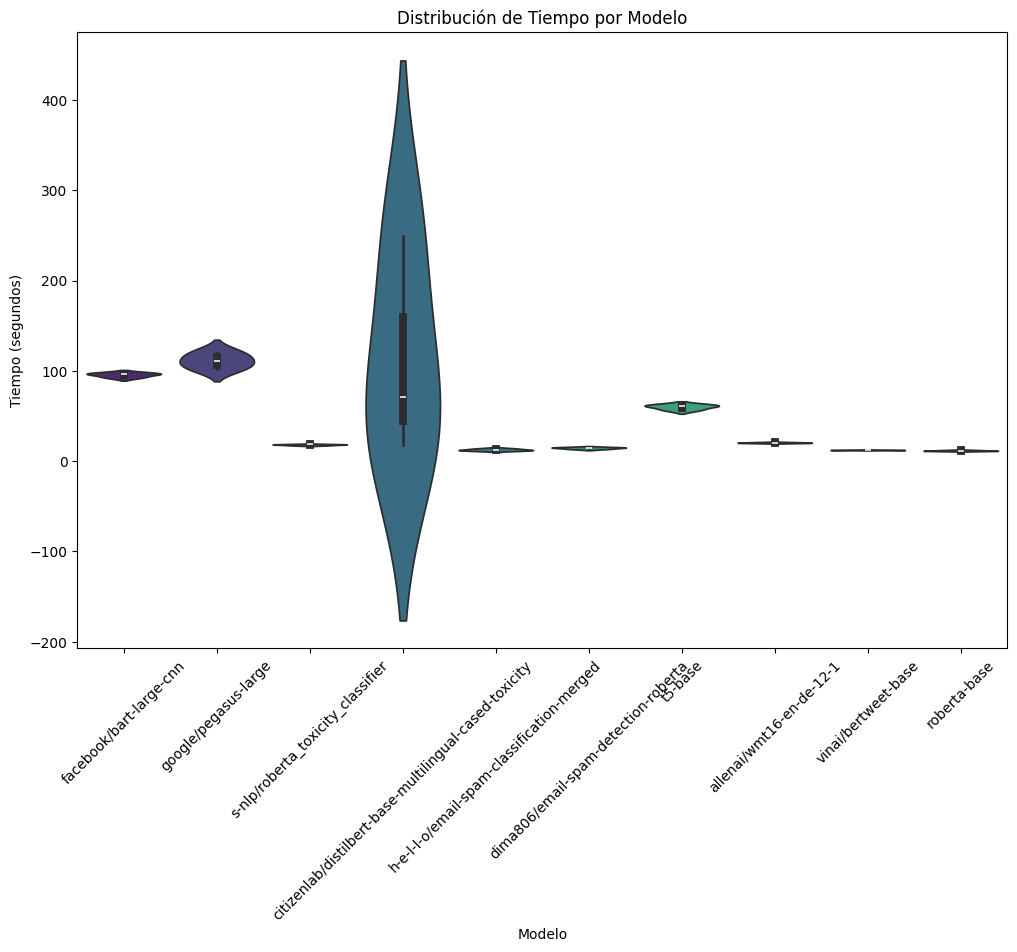

In [5]:
plt.figure(figsize=(12, 8))
sns.violinplot(x='Model', y='Time', data=df, palette='viridis')
plt.title('Distribución de Tiempo por Modelo')
plt.xlabel('Modelo')
plt.ylabel('Tiempo (segundos)')
plt.xticks(rotation=45)
plt.show()

Distribución de Tiempo por Perturbación

/var/folders/wx/mr55ds4s2h51z7w0fl0gb1yw0000gn/T/ipykernel_1238/932480529.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Perturbation', y='Time', data=df, palette='viridis')


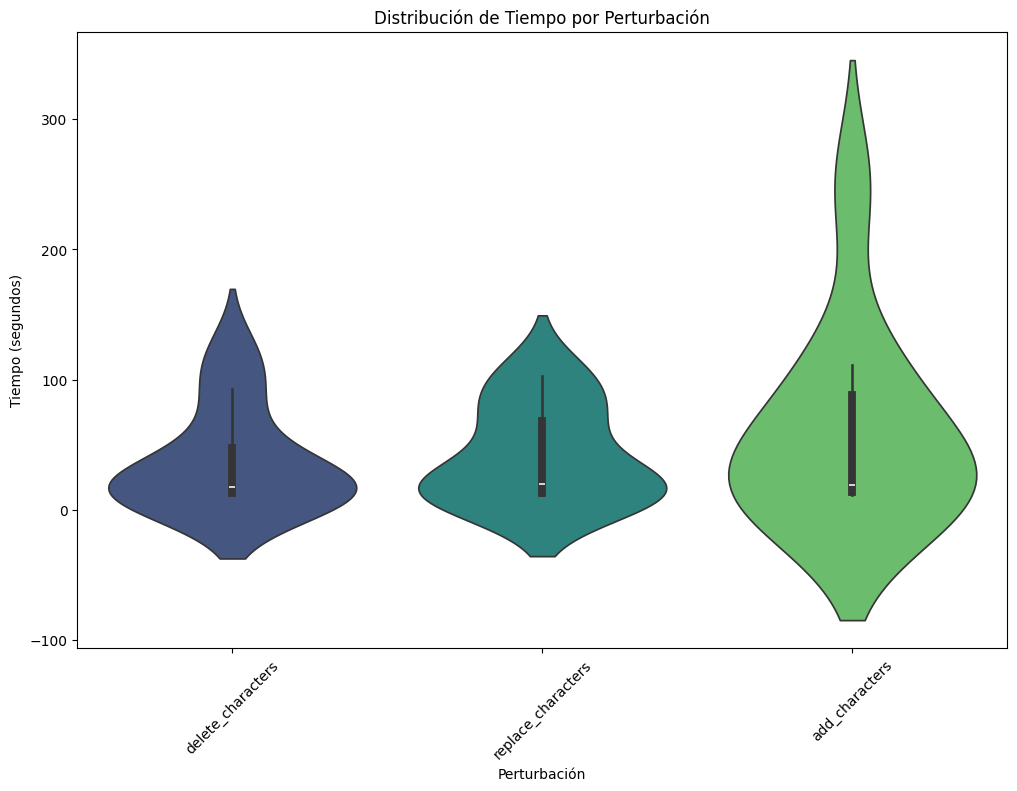

In [6]:
plt.figure(figsize=(12, 8))
sns.violinplot(x='Perturbation', y='Time', data=df, palette='viridis')
plt.title('Distribución de Tiempo por Perturbación')
plt.xlabel('Perturbación')
plt.ylabel('Tiempo (segundos)')
plt.xticks(rotation=45)
plt.show()